Issues with TimeSeriesSplit:  

https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data/105116#105116  

"I dont think even time series split cv is appropriate for time series prediction because it trains on those 4 blocks which capture very unique stretches of the variable's movement, in other words 4 market regimes, which are unlikely to re-appear out-of-sample. I think more randomization is needed while still retaining the order of time events. Cant bootstrap resampling with replacement be used within stacking?"

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
# Machine learning packages
# import xgboost as xgb

# Custom function for neg_mean_absolute_percentage_error
def neg_mean_absolute_percentage_error(y_true, y_pred):
    return -100 * np.mean(np.abs((y_true - y_pred) / y_true))

from Functions import *

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [10]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

#### Drop one version of the time variables (either cyclical or dummy versions)

In [11]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Delete the year variable

In [12]:
del Xfull['year']

#### Get the sensor locations (this is needed if splitting the data spatially in cross validation)

In [13]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

#### Get as series the sensor ids and datetimes

In [14]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [15]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [16]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

In [17]:
models_dict = {"rf_regressor":rf_model_pipeline}

### Cross validation manually 

#### Run cluster analysis

In [129]:
n_spatial_clusters = 10

In [315]:
Xfull['sensor_id'] = sensor_ids
# Get list of sensors which have data in this time block
list_sensors = Xfull['sensor_id'].unique().tolist()

##############################################################
# Run K-means clustering using just these sensors (i.e. with data in this timeslice)
# Based on coordinates of sensors
##############################################################            
# Get dataframe containing coordinates for these sensors
coordinates_to_cluster = melbourne_sensors[['Latitude','Longitude']].copy()   

# Initialize KMeans instance
kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
# coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

##############################################################
# Join back on to main dataset (X) 
# So now X includes a column containing the cluster number of each row
# If the row is from a sensor not present in this timeslice, it will have NA
# Rows not within this timeslice, but with a sensor ID present in this timeslice
# will get the cluster number for that sensor in this timeslice, but this will be overridden
# in the future when that timeslice is considered
##############################################################      
# Remove a cluster number column if it was already created in previous iteration
if 'Cluster_number' in Xfull.columns:
    Xfull = Xfull.drop('Cluster_number', axis=1)

# Join the cluster number back onto the dataset of sensors present in this timeslice
melbourne_sensors['Cluster_number'] = kmeans.labels_

# Join this onto X (so now all rows with that sensor_id will show as being in that cluster)
# Including rows not within this timeslice, but this shouldn't matter
Xfull = pd.merge(Xfull, melbourne_sensors[['sensor_id','Cluster_number']], on='sensor_id', how='left')

### Join the two clusters on edge

In [316]:
melbourne_sensors.loc[melbourne_sensors.Cluster_number ==4 , 'Cluster_number'] = 3  
Xfull.loc[Xfull.Cluster_number ==4 , 'Cluster_number'] = 3  

melbourne_sensors.loc[melbourne_sensors.Cluster_number ==5 , 'Cluster_number'] = 3  
Xfull.loc[Xfull.Cluster_number ==5 , 'Cluster_number'] = 3  

### Add points north of dock to this cluster

In [281]:
# melbourne_sensors.loc[melbourne_sensors.Cluster_number ==4 , 'Cluster_number'] = 3  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==11 , 'Cluster_number'] =3  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==12 , 'Cluster_number'] =3  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==77 , 'Cluster_number'] =3  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==78 , 'Cluster_number'] =3  

In [260]:
# Xfull.loc[Xfull.Cluster_number ==4 , 'Cluster_number'] = 3   
# Xfull.loc[Xfull.sensor_id ==11 , 'Cluster_number'] =3  
# Xfull.loc[Xfull.sensor_id ==12 , 'Cluster_number'] =3  
# Xfull.loc[Xfull.sensor_id ==77 , 'Cluster_number'] =3  
# Xfull.loc[Xfull.sensor_id ==78 , 'Cluster_number'] =3  

In [202]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==91 , 'Cluster_number'] =9 
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==92 , 'Cluster_number'] =9  
# Xfull.loc[Xfull.sensor_id ==91 , 'Cluster_number'] =9  
# Xfull.loc[Xfull.sensor_id ==92 , 'Cluster_number'] =9  

### Join southern clusters

In [317]:
melbourne_sensors.loc[melbourne_sensors.Cluster_number ==1 , 'Cluster_number'] = 7  
Xfull.loc[Xfull.Cluster_number ==1 , 'Cluster_number'] = 7  

### Add south of river blue to the south of river cluster

In [318]:
melbourne_sensors.loc[melbourne_sensors.sensor_id ==14 , 'Cluster_number'] =9 
melbourne_sensors.loc[melbourne_sensors.sensor_id ==28 , 'Cluster_number'] =9  
melbourne_sensors.loc[melbourne_sensors.sensor_id ==29 , 'Cluster_number'] =9 
melbourne_sensors.loc[melbourne_sensors.sensor_id ==35 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==14 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==28, 'Cluster_number'] =9 
Xfull.loc[Xfull.sensor_id ==29 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==35 , 'Cluster_number'] =9  

In [319]:
melbourne_sensors.loc[melbourne_sensors.sensor_id ==8 , 'Cluster_number'] =9  
Xfull.loc[Xfull.sensor_id ==8 , 'Cluster_number'] =9  

In [220]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==8 , 'Cluster_number'] =9 
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==9 , 'Cluster_number'] =9  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==23 , 'Cluster_number'] =9 
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==24 , 'Cluster_number'] =9  
# Xfull.loc[Xfull.sensor_id ==8 , 'Cluster_number'] =9  
# Xfull.loc[Xfull.sensor_id ==9 , 'Cluster_number'] =9 
# Xfull.loc[Xfull.sensor_id ==23 , 'Cluster_number'] =9  
# Xfull.loc[Xfull.sensor_id ==24 , 'Cluster_number'] =9  

In [223]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==10 , 'Cluster_number'] =1 
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==57 , 'Cluster_number'] =1  
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==58 , 'Cluster_number'] =1 
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==73 , 'Cluster_number'] =1  
# Xfull.loc[Xfull.sensor_id ==10, 'Cluster_number'] =1  
# Xfull.loc[Xfull.sensor_id ==57 , 'Cluster_number'] =1 
# Xfull.loc[Xfull.sensor_id ==58 , 'Cluster_number'] =1  
# Xfull.loc[Xfull.sensor_id ==73 , 'Cluster_number'] =1  

In [230]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==27 , 'Cluster_number'] =3
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==64 , 'Cluster_number'] =3  
# Xfull.loc[Xfull.sensor_id ==27, 'Cluster_number'] =3  
# Xfull.loc[Xfull.sensor_id ==64 , 'Cluster_number'] =3  

In [234]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==20 , 'Cluster_number'] =6
# Xfull.loc[Xfull.sensor_id ==20, 'Cluster_number'] =6  

In [237]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==36 , 'Cluster_number'] =9
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==14 , 'Cluster_number'] =9
# Xfull.loc[Xfull.sensor_id ==36, 'Cluster_number'] =9
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==14 , 'Cluster_number'] =9

In [247]:
# melbourne_sensors.loc[melbourne_sensors.sensor_id ==13 , 'Cluster_number'] = 1  
# Xfull.loc[Xfull.sensor_id ==13 , 'Cluster_number'] = 1  

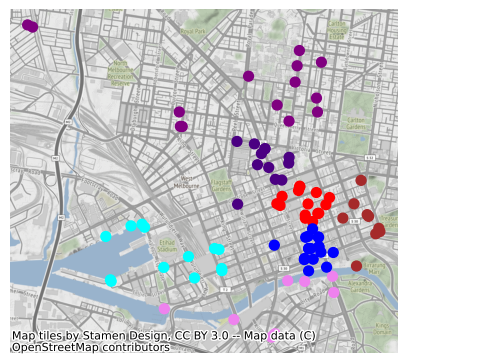

In [320]:
fig, ax = plt.subplots(figsize=(5,5))
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude,
                                    melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')
colors_ls = ['black'] * n_spatial_clusters
color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange','brown','cyan', 'indigo', 'violet']

# If there's just one temporal split, just make one plot
my_plot = gdf.plot(column=gdf.Cluster_number, ax = ax, markersize = 50, cmap=colors.ListedColormap(color))
cx.add_basemap(ax = ax)
ax.axis('off')
ax.set_axis_off()

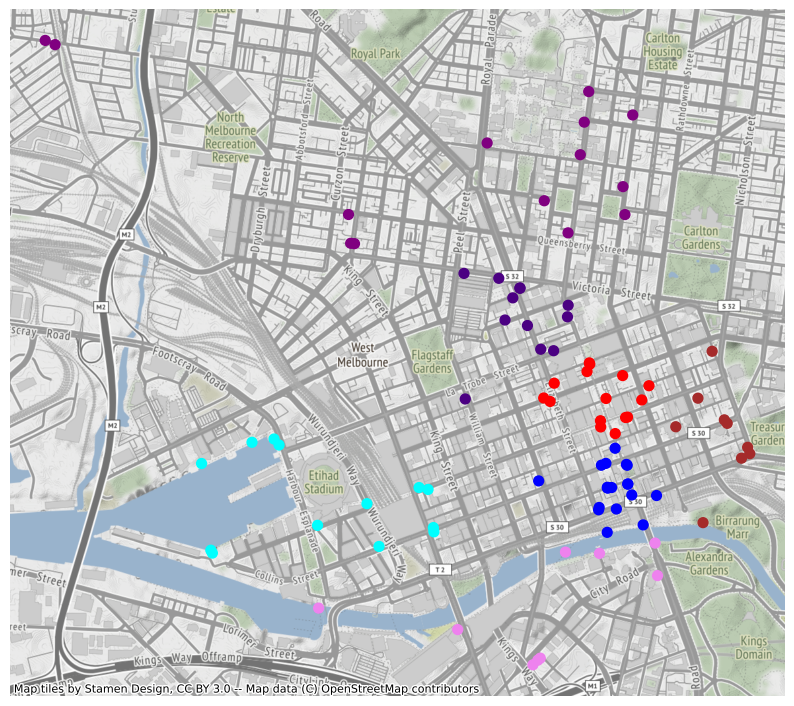

In [295]:
fig, ax = plt.subplots(figsize=(10,10))
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude,
                                    melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')
colors_ls = ['black'] * n_spatial_clusters
color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange','brown','cyan', 'indigo', 'violet']

# If there's just one temporal split, just make one plot
my_plot = gdf.plot(column=gdf.Cluster_number, ax = ax, markersize = 50, cmap=colors.ListedColormap(color))
cx.add_basemap(ax = ax)
ax.axis('off')
ax.set_axis_off()

### Check differences in number of sensors in each cluster

In [321]:
for cluster_num in np.sort(Xfull['Cluster_number'].unique()):
    print(cluster_num, len(Xfull[Xfull['Cluster_number']==cluster_num]))

0 845764
2 629544
3 535381
6 558890
7 647493
8 444203
9 467807


In [110]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [290]:
train_index = Xfull.index[Xfull['Cluster_number'] != cluster_num].tolist()
test_index = Xfull.index[Xfull['Cluster_number'] == cluster_num].tolist()

# Get train and testing data for this fold
print(f"train index: {len(train_index)}")
print(f"test index: {len(test_index)}")

print(len(test_index)/len(train_index)*100)

train index: 3763536
test index: 365546
9.712833888130737


In [298]:
start = time()
train_idx = Xfull.index[Xfull['Cluster_number'] != 5].tolist()
test_idx = Xfull.index[Xfull['Cluster_number'] == 5].tolist()

# Loop through each of the cross validation splits
for cluster_num in Xfull['Cluster_number'].unique():
    
    train_index = Xfull.index[Xfull['Cluster_number'] != cluster_num].tolist()
    test_index = Xfull.index[Xfull['Cluster_number'] == cluster_num].tolist()
    
    # Get train and testing data for this fold
    print(f"train index: {len(train_index)}")
    print(f"test index: {len(test_index)}")
    print(len(test_index)/len(train_index)*100)
    X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
    y_train, y_test = Yfull[train_index], Yfull[test_index]
    # Fit the model on the training data
    rf_model_pipeline.fit(X_train, y_train)
    # Use it to make predictions on the testing data, and store these
    y_pred = rf_model_pipeline.predict(X_test)
    predicted_values.append(y_pred)
    # Store the datetimes
    datetimes_used.append(datetimes[train_index])
    # Store the actual values for the testing data
    observed_values.append(Yfull[y_test])
    # Calculate the error metrics for this fold and append to the scores lists
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]       

end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

train index: 3661275
test index: 467807
12.777160961686846
train index: 3283318
test index: 845764
25.759429942515467
train index: 3570192
test index: 558890
15.65434015873656
train index: 3481589
test index: 647493
18.597628841313547
train index: 3684879
test index: 444203
12.054751322906396
train index: 3499538
test index: 629544
17.989346022246366
train index: 3593701
test index: 535381
14.897761388607456


In [299]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

In [300]:
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

mean_mae, mean_r2, mean_rmse

(364.58573791896714, -1.4519083999792999, 551.7080795572534)

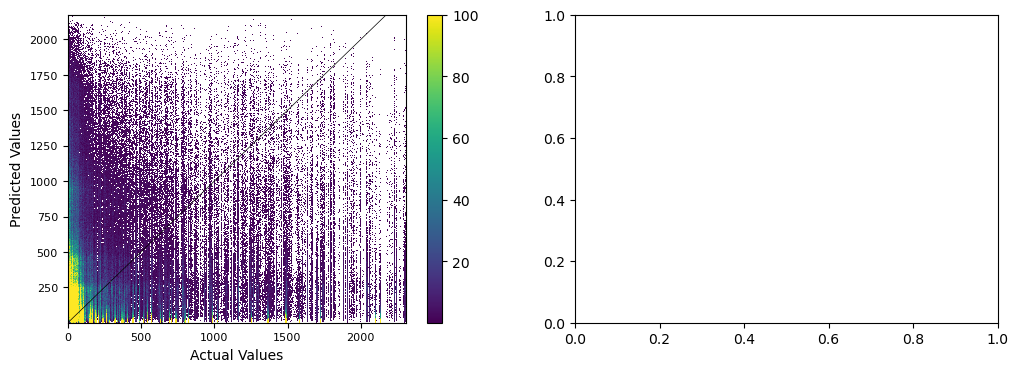

In [314]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values[6], predicted_values[6], 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)


In [307]:
predicted_values[0]

array([160.96, 129.87, 149.47, ...,  36.57,  57.07,  42.51])

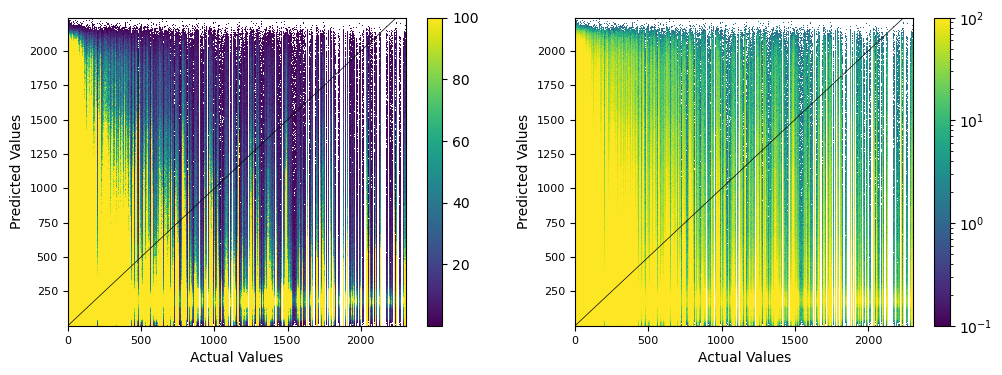

In [301]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values_all, predicted_values_all, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], observed_values_all, predicted_values_all, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

### Run model with cross validation

In [70]:
# cv_parameters = KFold(n_splits=2, random_state=1, shuffle=True)

rf_regressor
Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2013-10-23 20:00:00
Testing data is 13.6% of training data
Testing data is 4.3% of training data
Testing data is 2.1% of training data
Temporal split number 1
Start: 2013-10-23 20:00:00, end: 2015-05-09 09:00:00
Testing data is 17.0% of training data
Testing data is 3.9% of training data
Testing data is 2.0% of training data
Temporal split number 2
Start: 2015-05-09 09:00:00, end: 2016-08-02 03:00:00
Testing data is 16.3% of training data
Testing data is 3.2% of training data
Testing data is 2.4% of training data
Temporal split number 3
Start: 2016-08-02 03:00:00, end: 2017-11-04 11:00:00
Testing data is 15.9% of training data
Testing data is 3.2% of training data
Testing data is 2.6% of training data
Temporal split number 4
Start: 2017-11-04 11:00:00, end: 2018-11-17 10:00:00
Testing data is 13.7% of training data
Testing data is 4.1% of training data
Testing data is 2.5% of training data
Temporal split number 5
Sta

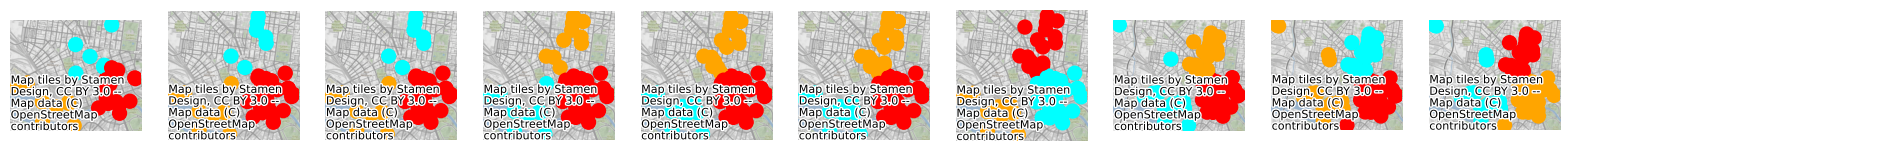

In [72]:
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=btss, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    # error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
# error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

### Print table showing error metrics associated with each model

In [74]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,308.28,6.565443e+15,1.23,469.12


In [ ]:
# #### Run cross_val_predict to get predictions
# start = time()
# predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=btss)
# end = time()
# print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))
# # Convert to a dataframe
# predictions_df=pd.DataFrame(predictions)
# # Store the predictions
# # predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   